# Recap linear regression

In this Notebook, I will show the optimal solution for the bol.com exercise.

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math

In [3]:
df = pd.read_csv('bol_sales.csv')
df.head()

,id,gender,income,distance_center,website_visits,pages_viewed,time_social_media,spent_bol
0,person_1,female,7065,4.6,30,105,117,1232
1,person_2,female,23028,9.8,23,81,70,1396
2,person_3,female,103377,9.2,11,38,94,1240
3,person_4,female,9815,3.2,16,54,124,720
4,person_5,female,22646,10.1,21,78,119,1379


## Exploratory data analysis

Let's start with investigating the relationship between the dependent variable (*spent_bol*) and the other variables.

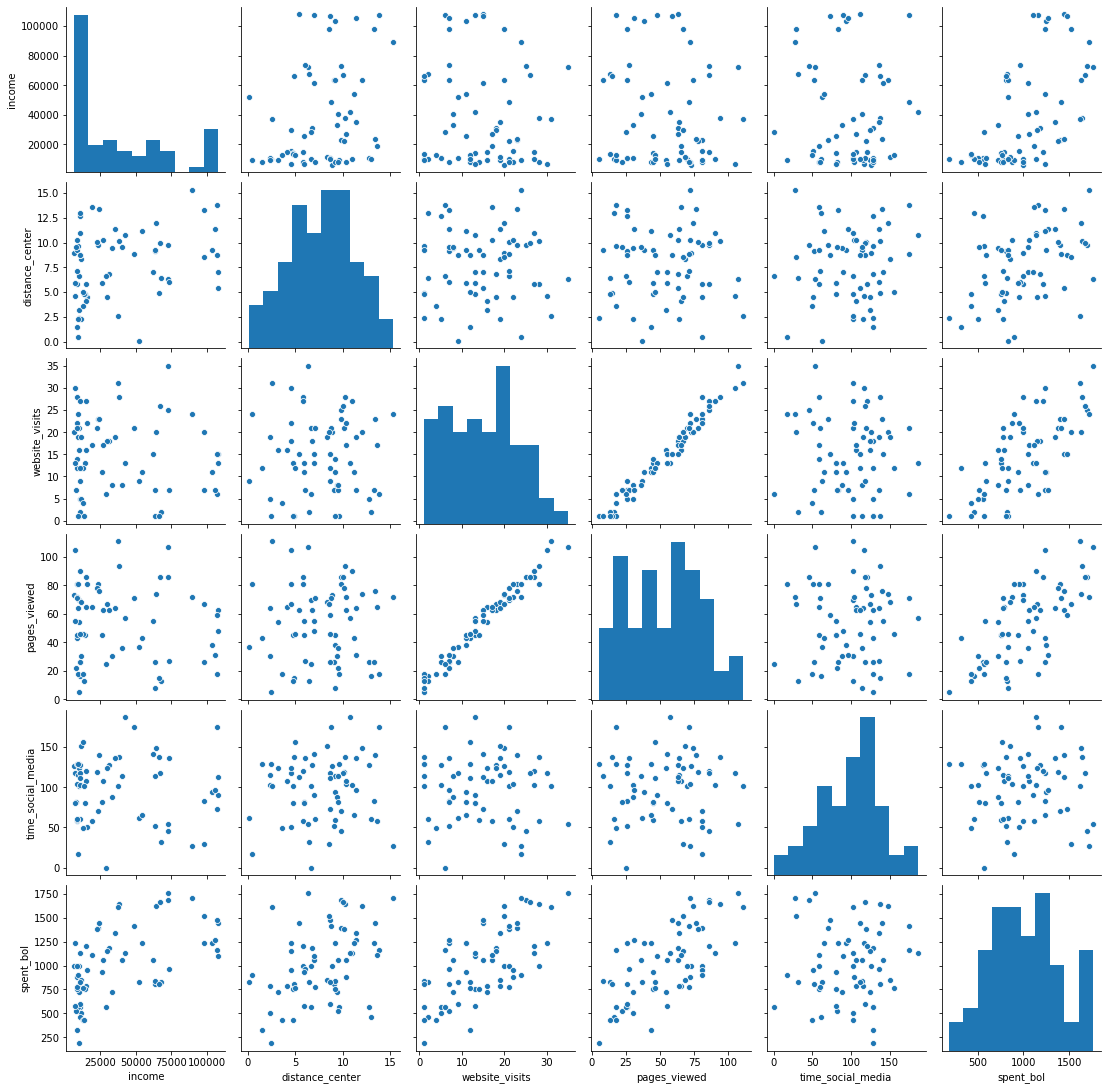

In [4]:
sns.pairplot(df)
plt.show()

Some conclusions:
* *spent_bol* seems linearly related to *distance_center*, *website_visits*, *pages_viewed*. It doesn't seem very correlated with *time_social_media*
* The relation with *income* does not seem exactly linear. Needs further investigation.
* *pages_viewed* is strongly correlated with *website_visits*. None of the other variables seem correlated with each other.

Let's express those correlations in numbers:

In [10]:
df.corr()

,income,distance_center,website_visits,pages_viewed,time_social_media,spent_bol
income,1.000000,0.298612,-0.085088,-0.095738,-0.065139,0.565621
distance_center,0.298612,1.000000,0.006597,-0.016633,0.093626,0.392954
website_visits,-0.085088,0.006597,1.000000,0.983754,-0.035425,0.677874
pages_viewed,-0.095738,-0.016633,0.983754,1.000000,-0.000302,0.682696
time_social_media,-0.065139,0.093626,-0.035425,-0.000302,1.000000,0.034558
spent_bol,0.565621,0.392954,0.677874,0.682696,0.034558,1.000000


The numbers support the intuitions based on the scatterplot above. The variable *time_social_media* is so weakly correlated, that it might well be total coincidence. Let's have a look at the categorical variable *gender*.

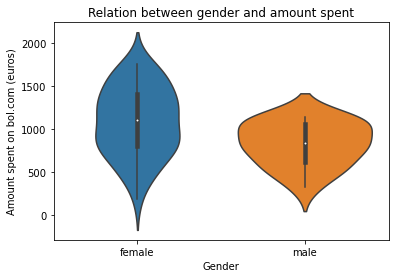

In [7]:
sns.violinplot(x='gender', y='spent_bol', data=df)
plt.title("Relation between gender and amount spent")
plt.ylabel("Amount spent on bol.com (euros)")
plt.xlabel("Gender")
plt.show()

There is a clear relation between *gender* and *spent_bol* with females spending more on average. Let's investigate the non-linear relationship with income.

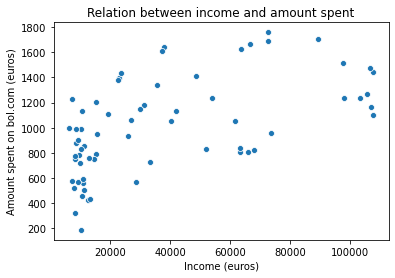

In [9]:
sns.scatterplot(x='income', y='spent_bol', data=df)
plt.title("Relation between income and amount spent")
plt.ylabel("Amount spent on bol.com (euros)")
plt.xlabel("Income (euros)")
plt.show()

The relationship seems to be more logarithmic than linear. Which makes sense, you can only spend so much on online shopping. Let's apply a logarithmic transformation to see what happens.

## Variable transformations

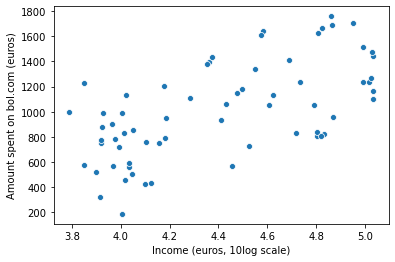

In [12]:
df['income_log']= df['income'].apply(math.log10) #creates a variable with income on 10log scale
sns.scatterplot(x='income_log', y='spent_bol', data=df)
plt.ylabel("Amount spent on bol.com (euros)")
plt.xlabel("Income (euros, 10log scale)")
plt.show()

Now the relationship is clearly linear. Now let's get the dummy variables for gender and add them to the dataframe.

In [13]:
dummies = pd.get_dummies(df['gender'])
pd.get_dummies(df['gender'])
df = pd.concat([df, dummies], axis=1)
df.head()

,id,gender,income,distance_center,website_visits,pages_viewed,time_social_media,spent_bol,income_log,female,male
0,person_1,female,7065,4.6,30,105,117,1232,3.849112,1,0
1,person_2,female,23028,9.8,23,81,70,1396,4.362256,1,0
2,person_3,female,103377,9.2,11,38,94,1240,5.014424,1,0
3,person_4,female,9815,3.2,16,54,124,720,3.991890,1,0
4,person_5,female,22646,10.1,21,78,119,1379,4.354992,1,0


## Building the model

Let's build our model. We'll use:
* The <sup>10</sup>log of *income*
* *distance_center*
* *website_visits*
* *female*

We **don't** use:

* *pages_viewed*: it's too strongly correlated with *website_visits*. If we include both, one will "mask" the other and the model will have a hard time assigning correct coefficients to both. This will worsen the model's performance.
* *time_social_media*: it's so weakly correlated that it might be purely due to chance. If that's the case, our model will be worse if we include it.
* *male*: with a categorical variable with two levels, you can only include one dummy variable.

In [14]:
X = df[['income_log', 'distance_center', 'website_visits', 'female']] #select the X-variables
X.head()

,income_log,distance_center,website_visits,female
0,3.849112,4.6,30,1
1,4.362256,9.8,23,1
2,5.014424,9.2,11,1
3,3.991890,3.2,16,1
4,4.354992,10.1,21,1


In [15]:
y = df['spent_bol']

Let's fit the model:

In [20]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X,y)
print(f"Intercept {lm.intercept_}")
print(f"Coefficients  {lm.coef_}")


Intercept -2047.2784850995363
Coefficients  [517.3542101   26.3249302   30.80746797 162.35505322]


The way to interpret this is as follows. On average:
    
* With every power of 10 (x10) increase in income, amount spent increases by 517 euros
* With every km to the center, amount spent increases by 26 euros
* With every website visit, amount spent increases by 31 euros
* Females spend on average 162 euros more


## Evaluating the model

Let's use our model to predict the amount spent. In this case, we're using the same data for training set as test set, because we also have a hold-out test set.

In [21]:
y_pred = lm.predict(X)

In [22]:
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(df['spent_bol'],y_pred)) #get the RMSE

63.74979362634674

The model has a typical error (RMSE) of 63.7 euros. 

## Evaluating on the hold-out test set

Let's evaluate the model on the hold-out test set. We didn't use these data to generate the coefficients. Typically, one would expect worse results on the hold-out test set, although this is not a hard and fast rule.

In [24]:
df_ho = pd.read_csv('bol_sales_holdout.csv')

dummies = pd.get_dummies(df_ho['gender']) #we need to create the dummy variables, because this new dataset doesn't have them
df_ho = pd.concat([df_ho, dummies], axis=1)

df_ho['income_log']= df_ho['income'].apply(math.log10) #same for the log transformations

X_ho = df_ho[['income_log', 'distance_center', 'website_visits', 'female']] #selecting the X variables

Now let's predict the results. Note that we are using the model trained on the original data, but predict the amount spent in the hold-out dataset.

In [25]:
y_pred_ho = lm.predict(X_ho)
math.sqrt(mean_squared_error(df_ho['spent_bol'],y_pred_ho)) #get the RMSE

83.92373028885666

The model has a typical error (RMSE) of 83.9 euros on the hold-out dataset. Note that this is indeed somewhat worse than on the original (training) dataset.